# Tutorial 2.2: Inputs, Files, and Scans

## 2.2.0: Python Imports

In [237]:
%run Tutorial_2_Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
%run Tutorial_2_Paths.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2.2.x Create `.def` definition files

First, we will create the two fragment definition files. First, the definition for the CH3NH2 fragment:

In [3]:
fragment_CH3NH2_definition = BasicFragmentDefinition()
CA  = fragment_CH3NH2_definition.add_atom(AtomDefinition("C", "A"))
HB1 = fragment_CH3NH2_definition.add_atom(AtomDefinition("H", "B"))
HB2 = fragment_CH3NH2_definition.add_atom(AtomDefinition("H", "B"))
HB3 = fragment_CH3NH2_definition.add_atom(AtomDefinition("H", "B"))
NC  = fragment_CH3NH2_definition.add_atom(AtomDefinition("N", "C"))
HD1 = fragment_CH3NH2_definition.add_atom(AtomDefinition("H", "D"))
HD2 = fragment_CH3NH2_definition.add_atom(AtomDefinition("H", "D"))
fragment_CH3NH2_definition.add_bond(CA, HB1, BondDefinition(BondType.SINGLE))
fragment_CH3NH2_definition.add_bond(CA, HB2, BondDefinition(BondType.SINGLE))
fragment_CH3NH2_definition.add_bond(CA, HB3, BondDefinition(BondType.SINGLE))
fragment_CH3NH2_definition.add_bond(CA, NC, BondDefinition(BondType.SINGLE))
fragment_CH3NH2_definition.add_bond(NC, HD1, BondDefinition(BondType.SINGLE))
fragment_CH3NH2_definition.add_bond(NC, HD2, BondDefinition(BondType.SINGLE))

write_fragment_definition(paths.definitions.fragments.CH3NH2, fragment_CH3NH2_definition)

The definition for the H2O fragment:

In [4]:
fragment_H2O_definition = BasicFragmentDefinition()
OE  = fragment_H2O_definition.add_atom(AtomDefinition("O", "E"))
HF1 = fragment_H2O_definition.add_atom(AtomDefinition("H", "F"))
HF2 = fragment_H2O_definition.add_atom(AtomDefinition("H", "F"))
fragment_H2O_definition.add_bond(OE, HF1, BondDefinition(BondType.SINGLE))
fragment_H2O_definition.add_bond(OE, HF2, BondDefinition(BondType.SINGLE))

write_fragment_definition(paths.definitions.fragments.H2O, fragment_H2O_definition)

Next, we will make three n-mer definitions.

First, the CH3NH2 monomer, which has a single CH3NH2 fragment.

In [5]:
definition_CH3NH2 = BasicCompoundDefinition()
definition_CH3NH2.add_fragment(fragment_CH3NH2_definition)

write_definition(paths.definitions.systems.CH3NH2, definition_CH3NH2)

First, the H2O monomer, which has a single CH3NH2 fragment.

In [6]:
definition_H2O = BasicCompoundDefinition()
definition_H2O.add_fragment(fragment_H2O_definition)

write_definition(paths.definitions.systems.H2O, definition_H2O)

Next, the CH3NH2 -- H2O dimer, with two fragments:

In [7]:
definition_CH3NH2_H2O = BasicCompoundDefinition()
definition_CH3NH2_H2O.add_fragment(fragment_CH3NH2_definition)
definition_CH3NH2_H2O.add_fragment(fragment_H2O_definition)

write_definition(paths.definitions.systems.CH3NH2_H2O, definition_CH3NH2_H2O)

Finally, the CH3NH2 -- H2O -- H2O trimer, with three fragments:

In [8]:
definition_CH3NH2_H2O_H2O = BasicCompoundDefinition()
definition_CH3NH2_H2O_H2O.add_fragment(fragment_CH3NH2_definition)
definition_CH3NH2_H2O_H2O.add_fragment(fragment_H2O_definition)
definition_CH3NH2_H2O_H2O.add_fragment(fragment_H2O_definition)

write_definition(paths.definitions.systems.CH3NH2_H2O_H2O, definition_CH3NH2_H2O_H2O)

We will use these definition files throughout Tutorial 2.

## 2.2.x Geometry Initialization

Next, we need a reasonable initial guess for the structure of our monomer. The guess need only be good enough that it will covnerge to the actual minimum structure when we perform a minimization with DFT. MB-Fit contains the class `VESPRInitializer`, which will make a reasonable guess about the structure of a molecule based on its bonding topology. Let's use `VESPRInitializer` to create an initial structure file:

In [9]:
system_initializer = VSEPRInitializer(seed=12345)

In [10]:
definition_CH3NH2 = read_definition(paths.definitions.systems.CH3NH2)
initialized_structure_CH3NH2 = system_initializer(definition_CH3NH2)
write_system(paths.structures.initialized_CH3NH2, initialized_structure_CH3NH2)

Initializing compound C1H3N1H2
System initialization complete!


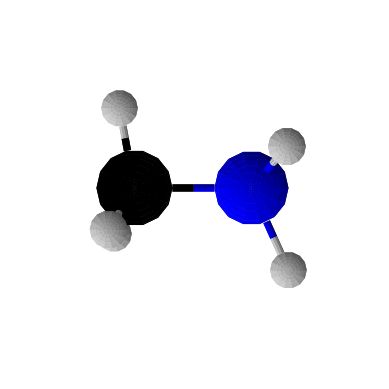

In [11]:
render_system(
        initialized_structure_CH3NH2,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[4].point, system.atoms[3].point)
)

In [12]:
definition_H2O = read_definition(paths.definitions.systems.H2O)
initialized_structure_H2O = system_initializer(definition_H2O)
write_system(paths.structures.initialized_H2O, initialized_structure_H2O)

Initializing compound O1H2
System initialization complete!


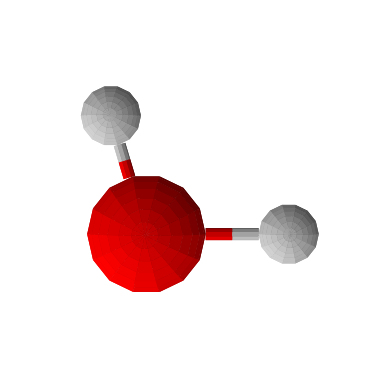

In [13]:
render_system(
        initialized_structure_H2O,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[1].point, system.atoms[2].point)
)

## 2.2.x Geometry Minimization

That guess is looking a little rough, lets optimize it using electronic structure theory. While the PEF will be developed at the CCSD(T) level of theory, its not important that the geometry optimization be at the same level of theory as the reference energies will be calculated at, so lets use something cheaper like a high-quality DFT functional.

In [14]:
# calculator = QchemCalculator("wB97M-V", "AUG-cc-pVTZ", log_directory=f"{logs_dir}")
calculator = QchemCalculator("HF", "STO-3G", log_directory=f"{logs_dir}")

In [248]:
minimized_structure_CH3NH2, minimized_energy_CH3NH2 = minimize_structure(
        initialized_structure_CH3NH2,
        calculator=calculator,
        job_manager=get_qchem_job_manager(paths.jobs),
        restart_path=paths.restart.minimization_CH3NH2,
        num_threads=16,
        mem_mb=32000
)
write_system(paths.structures.minimized_CH3NH2, minimized_structure_CH3NH2)

Minimizing geometries:  |====================================================================================================| - 1/1
Completed geometry minimizations!


In [249]:
minimized_structure_H2O, minimized_energy_H2O = minimize_structure(
        initialized_structure_H2O,
        calculator=calculator,
        job_manager=get_qchem_job_manager(paths.jobs),
        restart_path=paths.restart.minimization_H2O,
        num_threads=16,
        mem_mb=32000
)
write_system(paths.structures.minimized_H2O, minimized_structure_H2O)

Minimizing geometries:  |====================================================================================================| - 1/1
Completed geometry minimizations!


Great, now lets get the energies of these structures.

In [17]:
# minimized_energy_CH3NH2 = calculate_energy(
#         minimized_structure_CH3NH2,
#         calculator,
#         get_qchem_job_manager(paths.jobs),
#         restart_path=paths.restart.energy_minimized_CH3NH2,
#         16,
#         32000
# )
# write_system_and_energy(monomer_CH3NH2_minimum_structure_path, (minimized_structure_CH3NH2, minimized_energy_CH3NH2))

In [18]:
# minimized_energy_H2O = calculate_energy(
#         minimized_structure_H2O,
#         calculator,
#         get_qchem_job_manager(paths.jobs),
#         restart_path=paths.restart.energy_minimized_H2O,
#         16,
#         32000
# )
# write_system_and_energy(monomer_H2O_minimum_structure_path, (minimized_structure_H2O, minimized_energy_H2O))

Plotting

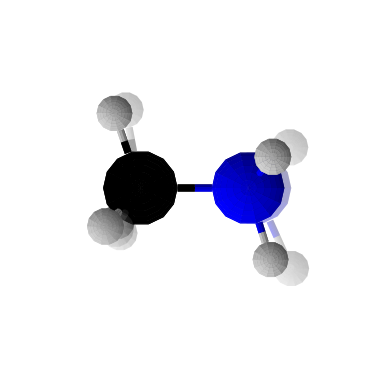

In [19]:
render_overlayed_systems(
    [initialized_structure_CH3NH2, minimized_structure_CH3NH2],
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=(0.2, 1.0)
)

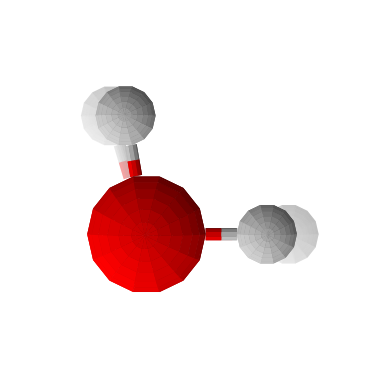

In [20]:
render_overlayed_systems(
    [initialized_structure_H2O, minimized_structure_H2O],
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[1].point, system.atoms[2].point),
    alpha=(0.2, 1.0)
)

## 2.2.2 Two-Body Scans

Now we make a few two-body scans. We will use these during future steps to validate the quality of the 2-body parts of the PEF.

Lets generate a few 2-body CH$_3$-NH$_2$ -- H$_2$O scans. We will make three scans.

In [21]:
dimer_CH3NH2_H2O = BasicCompound(definition_CH3NH2_H2O)

dimer_CH3NH2_H2O.fragments[0].set_xyz(paths.structures.minimized_CH3NH2)
dimer_CH3NH2_H2O.fragments[1].set_xyz(paths.structures.minimized_H2O)

monomer_CH3NH2 = dimer_CH3NH2_H2O.fragments[0]
monomer_H2O = dimer_CH3NH2_H2O.fragments[1]

H-bond between H on -NH$_2$ and O in H$_2$O:

In [22]:
scan_CH3NH2_H2O_1 = make_scan(
        system=dimer_CH3NH2_H2O,
        region1=monomer_CH3NH2,
        region2=monomer_H2O,
        center1=monomer_CH3NH2.atoms[5].point,
        center2=monomer_H2O.atoms[0].point,
        align1=[monomer_CH3NH2.atoms[5].point-monomer_CH3NH2.atoms[4].point, monomer_CH3NH2.atoms[5].point-monomer_CH3NH2.atoms[0].point],
        align2=[monomer_H2O.atoms[1].point-monomer_H2O.atoms[0].point + monomer_H2O.atoms[2].point-monomer_H2O.atoms[0].point, monomer_H2O.atoms[1].point - monomer_H2O.atoms[0].point],
        distances=numpy.arange(1.0, 10.5, 0.5)
)

write_systems(paths.scans.CH3NH2_H2O.first, scan_CH3NH2_H2O_1)

In [23]:
HTML(render_systems(
        scan_CH3NH2_H2O_1,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[7].point, system.atoms[0].point)
).to_jshtml())

H-bond between H on H$_2$O and N in -NH$_2$:

In [24]:
scan_CH3NH2_H2O_2 = make_scan(
        system=dimer_CH3NH2_H2O,
        region1=monomer_CH3NH2,
        region2=monomer_H2O,
        center1=monomer_CH3NH2.atoms[4].point,
        center2=monomer_H2O.atoms[1].point,
        align1=(monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[0].point + monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[5].point + monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[6].point, monomer_CH3NH2.atoms[0].point-monomer_CH3NH2.atoms[4].point),
        align2=(monomer_H2O.atoms[0].point-monomer_H2O.atoms[1].point, monomer_H2O.atoms[2].point-monomer_H2O.atoms[1].point),
        distances=numpy.arange(1.0, 10.5, 0.5)
)

write_systems(paths.scans.CH3NH2_H2O.second, scan_CH3NH2_H2O_2)

In [25]:
HTML(render_systems(
        scan_CH3NH2_H2O_2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[7].point, system.atoms[0].point)
).to_jshtml())

H from -CH$_3$ approaching O in H$_2$O

In [26]:
scan_CH3NH2_H2O_3 = make_scan(
        system=dimer_CH3NH2_H2O,
        region1=monomer_CH3NH2,
        region2=monomer_H2O,
        center1=monomer_CH3NH2.atoms[1].point,
        center2=monomer_H2O.atoms[0].point,
        align1=(monomer_CH3NH2.atoms[1].point-monomer_CH3NH2.atoms[0].point, monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[1].point),
        align2=(monomer_H2O.atoms[1].point-monomer_H2O.atoms[0].point + monomer_H2O.atoms[2].point-monomer_H2O.atoms[0].point, monomer_H2O.atoms[1].point-monomer_H2O.atoms[0].point),
        distances=numpy.arange(1.0, 10.5, 0.5)
)

write_systems(paths.scans.CH3NH2_H2O.third, scan_CH3NH2_H2O_3)

In [27]:
HTML(render_systems(
        scan_CH3NH2_H2O_3,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[7].point, system.atoms[4].point)
).to_jshtml())

Now, lets perform the reference calculations for the scans.

In [28]:
# calculator = OrcaCalculator("DLPNO-CCSD(T)-F12", "cc-pVTZ-F12", log_directory="test_logs", command_line_args = ["VeryTightSCF", "TightPNO", "PModel"], basis_args = {"AuxC": "cc-pVTZ/C", "CABS": "cc-pVTZ-F12-CABS"})
# calculator = OrcaCalculator("DLPNO-CCSD(T)", "cc-pVDZ-F12", log_directory="test_logs", command_line_args = ["VeryTightSCF", "TightPNO", "PModel"], basis_args = {"AuxC": "cc-pVDZ/C"})
calculator = QchemCalculator("HF", "STO-3G", log_directory=f"{logs_dir}")

In [252]:
scan_CH3NH2_H2O_1_energies = calculate_nmer_energies(
        scan_CH3NH2_H2O_1,
        calculator,
        get_qchem_job_manager(paths.jobs),
        paths.restart.scans_CH3NH2_H2O_1_energies,
        num_threads=16,
        mem_mb=32000
)
write_systems_and_nmer_energies(paths.scans.CH3NH2_H2O.first_energies, (scan_CH3NH2_H2O_1, scan_CH3NH2_H2O_1_energies))

Running energy calculations |====================================================================================================| - 57/57
Completed n-mer energy calculations!


In [253]:
scan_CH3NH2_H2O_2_energies = calculate_nmer_energies(
        scan_CH3NH2_H2O_2,
        calculator,
        get_qchem_job_manager(paths.jobs),
        paths.restart.scans_CH3NH2_H2O_2_energies,
        num_threads=16,
        mem_mb=32000
)
write_systems_and_nmer_energies(paths.scans.CH3NH2_H2O.second_energies, (scan_CH3NH2_H2O_2, scan_CH3NH2_H2O_2_energies))

Running energy calculations |====================================================================================================| - 57/57
Completed n-mer energy calculations!


In [254]:
scan_CH3NH2_H2O_3_energies = calculate_nmer_energies(
        scan_CH3NH2_H2O_3,
        calculator,
        get_qchem_job_manager(paths.jobs),
        paths.restart.scans_CH3NH2_H2O_3_energies,
        num_threads=16,
        mem_mb=32000
)
write_systems_and_nmer_energies(paths.scans.CH3NH2_H2O.third_energies, (scan_CH3NH2_H2O_3, scan_CH3NH2_H2O_3_energies))

Running energy calculations |====================================================================================================| - 57/57
Completed n-mer energy calculations!


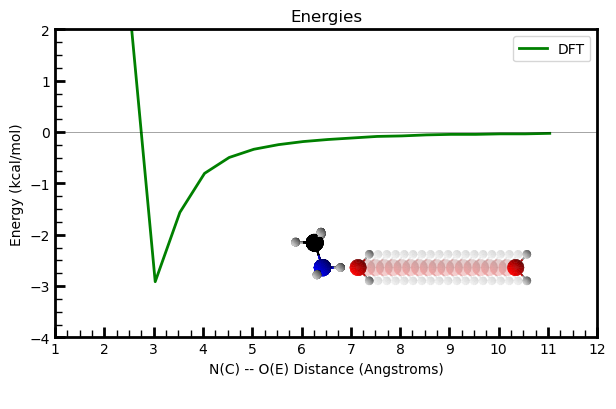

In [255]:
scan_CH3NH2_H2O_1_2b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_1, scan_CH3NH2_H2O_1_energies)

plot_scan(
        scan_CH3NH2_H2O_1,
        {"DFT": scan_CH3NH2_H2O_1_2b_energies},
        4,
        7,
        title="Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[7].point, system.atoms[0].point)
)

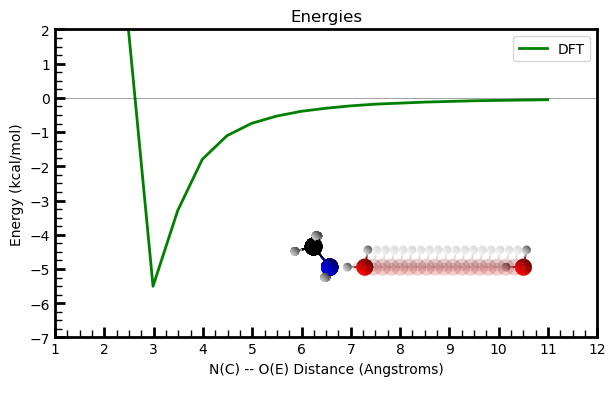

In [256]:
scan_CH3NH2_H2O_2_2b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_2, scan_CH3NH2_H2O_2_energies)

plot_scan(
        scan_CH3NH2_H2O_2,
        {"DFT": scan_CH3NH2_H2O_2_2b_energies},
        4,
        7,
        title="Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[7].point, system.atoms[0].point)
)

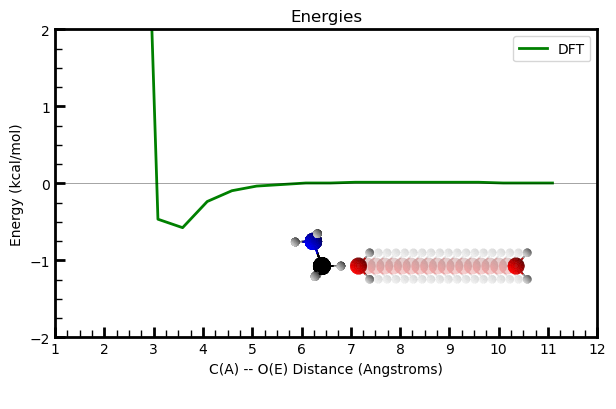

In [257]:
scan_CH3NH2_H2O_3_2b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_3, scan_CH3NH2_H2O_3_energies)

plot_scan(
        scan_CH3NH2_H2O_3,
        {"DFT": scan_CH3NH2_H2O_3_2b_energies},
        0,
        7,
        title="Energies",
        ymax=2,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[7].point, system.atoms[4].point)
)

## 2.2.3 Three-Body Scans

Now we make a few three-body scans. We will use these during future steps to validate the quality of the 2-body parts of the PEF.

Lets also consider a few 3-body structures. We will make three scans.

In [258]:
trimer_CH3NH2_H2O_H2O = BasicCompound(definition_CH3NH2_H2O_H2O)

trimer_CH3NH2_H2O_H2O.fragments[0].set_xyz(paths.structures.minimized_CH3NH2)
trimer_CH3NH2_H2O_H2O.fragments[1].set_xyz(paths.structures.minimized_H2O)
trimer_CH3NH2_H2O_H2O.fragments[2].set_xyz(paths.structures.minimized_H2O)

monomer_CH3NH2 = trimer_CH3NH2_H2O_H2O.fragments[0]
monomer_H2O_1 = trimer_CH3NH2_H2O_H2O.fragments[1]
monomer_H2O_2 = trimer_CH3NH2_H2O_H2O.fragments[2]

region_CH3NH2_H2O = BasicMutableRegionManager(trimer_CH3NH2_H2O_H2O).make_region([monomer_CH3NH2, monomer_H2O_1])
transformer_CH3NH2 = SystemTransformer(monomer_CH3NH2)
transformer_H2O_1 = SystemTransformer(monomer_H2O_1)

-NH$_2$ donating 2 H-bonds to 2 H$_2$Os, where one H$_2$O moves away:

In [260]:
transformer_CH3NH2.translate(translation=-monomer_CH3NH2.atoms[5].point)
transformer_H2O_1.translate(translation=-monomer_H2O_1.atoms[0].point)
transformer_CH3NH2.align(vectors_to_align=[-monomer_CH3NH2.atoms[4].point, monomer_CH3NH2.atoms[0].point])
transformer_H2O_1.align(vectors_to_align=[monomer_H2O_1.atoms[1].point + monomer_H2O_1.atoms[2].point, monomer_H2O_1.atoms[1].point])

# Make fixed H-bond 2.0 A long
transformer_H2O_1.translate(x=2.0)

scan_CH3NH2_H2O_H2O_1 = make_scan(
        system=trimer_CH3NH2_H2O_H2O,
        region1=region_CH3NH2_H2O,
        region2=monomer_H2O_2,
        center1=monomer_CH3NH2.atoms[6].point,
        center2=monomer_H2O_2.atoms[0].point,
        align1=[monomer_CH3NH2.atoms[6].point-monomer_CH3NH2.atoms[4].point, monomer_CH3NH2.atoms[6].point-monomer_CH3NH2.atoms[0].point],
        align2=[monomer_H2O_2.atoms[1].point-monomer_H2O_2.atoms[0].point + monomer_H2O_2.atoms[2].point-monomer_H2O_2.atoms[0].point, monomer_H2O_2.atoms[1].point - monomer_H2O_2.atoms[0].point],
        distances=numpy.arange(1.0, 10.5, 0.5)
)

write_systems(paths.scans.CH3NH2_H2O_H2O.first, scan_CH3NH2_H2O_H2O_1)

In [261]:
HTML(render_systems(
        scan_CH3NH2_H2O_H2O_1,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[-3].point, system.atoms[0].point)
).to_jshtml())

-NH$_2$ donating 1 H-bond and accepting 1 H-bond, where the H$_2$O that is accepting an H-bond moves away.

In [264]:
transformer_CH3NH2.translate(translation=-monomer_CH3NH2.atoms[4].point)
transformer_H2O_1.translate(translation=-monomer_H2O_1.atoms[1].point)
transformer_CH3NH2.align(vectors_to_align=[-monomer_CH3NH2.atoms[5].point-monomer_CH3NH2.atoms[6].point-monomer_CH3NH2.atoms[0].point, monomer_CH3NH2.atoms[0].point])
transformer_H2O_1.align(vectors_to_align=[monomer_H2O_1.atoms[0].point, monomer_H2O_1.atoms[2].point])

# Make fixed H-bond 2.0 A long
transformer_H2O_1.translate(x=2.0)

scan_CH3NH2_H2O_H2O_2 = make_scan(
        system=trimer_CH3NH2_H2O_H2O,
        region1=region_CH3NH2_H2O,
        region2=monomer_H2O_2,
        center1=monomer_CH3NH2.atoms[6].point,
        center2=monomer_H2O_2.atoms[0].point,
        align1=[monomer_CH3NH2.atoms[6].point-monomer_CH3NH2.atoms[4].point, monomer_CH3NH2.atoms[6].point-monomer_CH3NH2.atoms[0].point],
        align2=[monomer_H2O_2.atoms[1].point-monomer_H2O_2.atoms[0].point + monomer_H2O_2.atoms[2].point-monomer_H2O_2.atoms[0].point, monomer_H2O_2.atoms[1].point - monomer_H2O_2.atoms[0].point],
        distances=numpy.arange(1.0, 10.5, 0.5)
)

write_systems(paths.scans.CH3NH2_H2O_H2O.second, scan_CH3NH2_H2O_H2O_2)

In [265]:
HTML(render_systems(
        scan_CH3NH2_H2O_H2O_2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[-3].point, system.atoms[0].point)
).to_jshtml())

-NH$_2$ donating 1 H-bond and accepting 1 H-bond, where the H$_2$O that is donating an H-bond moves away.

In [266]:
transformer_CH3NH2.translate(translation=-monomer_CH3NH2.atoms[5].point)
transformer_H2O_1.translate(translation=-monomer_H2O_1.atoms[0].point)
transformer_CH3NH2.align(vectors_to_align=[-monomer_CH3NH2.atoms[4].point, monomer_CH3NH2.atoms[0].point])
transformer_H2O_1.align(vectors_to_align=[monomer_H2O_1.atoms[1].point + monomer_H2O_1.atoms[2].point, monomer_H2O_1.atoms[1].point])

# Make fixed H-bond 2.0 A long
transformer_H2O_1.translate(x=2.0)

scan_CH3NH2_H2O_H2O_3 = make_scan(
        system=trimer_CH3NH2_H2O_H2O,
        region1=region_CH3NH2_H2O,
        region2=monomer_H2O_2,
        center1=monomer_CH3NH2.atoms[4].point,
        center2=monomer_H2O_2.atoms[1].point,
        align1=[monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[5].point + monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[6].point + monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[0].point, monomer_CH3NH2.atoms[4].point-monomer_CH3NH2.atoms[0].point],
        align2=[monomer_H2O_2.atoms[0].point-monomer_H2O_2.atoms[1].point, monomer_H2O_2.atoms[2].point - monomer_H2O_2.atoms[0].point],
        distances=numpy.arange(1.0, 10.5, 0.5)
)

write_systems(paths.scans.CH3NH2_H2O_H2O.third, scan_CH3NH2_H2O_H2O_3)

In [267]:
HTML(render_systems(
        scan_CH3NH2_H2O_H2O_3,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[-3].point, system.atoms[0].point)
).to_jshtml())

In [268]:
# calculator = OrcaCalculator("DLPNO-CCSD(T)-F12", "cc-pVTZ-F12", log_directory="test_logs", command_line_args = ["VeryTightSCF", "TightPNO", "PModel"], basis_args = {"AuxC": "cc-pVTZ/C", "CABS": "cc-pVTZ-F12-CABS"})
calculator = QchemCalculator("HF", "STO-3G", log_directory=f"{logs_dir}")

In [ ]:
scan_CH3NH2_H2O_H2O_1_energies = calculate_nmer_energies(
        scan_CH3NH2_H2O_H2O_1,
        calculator,
        get_qchem_job_manager(paths.jobs),
        paths.restart.scans_CH3NH2_H2O_H2O_1_energies,
        num_threads=16,
        mem_mb=32000
)
write_systems_and_nmer_energies(paths.scans.CH3NH2_H2O_H2O.first_energies, (scan_CH3NH2_H2O_H2O_1, scan_CH3NH2_H2O_H2O_1_energies))

In [ ]:
scan_CH3NH2_H2O_H2O_2_energies = calculate_nmer_energies(
        scan_CH3NH2_H2O_H2O_2,
        calculator,
        get_qchem_job_manager(paths.jobs),
        paths.restart.scans_CH3NH2_H2O_H2O_2_energies,
        num_threads=16,
        mem_mb=32000
)
write_systems_and_nmer_energies(paths.scans.CH3NH2_H2O_H2O.second_energies, (scan_CH3NH2_H2O_H2O_2, scan_CH3NH2_H2O_H2O_2_energies))

In [ ]:
scan_CH3NH2_H2O_H2O_3_energies = calculate_nmer_energies(
        scan_CH3NH2_H2O_H2O_3,
        calculator,
        get_qchem_job_manager(paths.jobs),
        paths.restart.scans_CH3NH2_H2O_H2O_3_energies,
        num_threads=16,
        mem_mb=32000
)
write_systems_and_nmer_energies(paths.scans.CH3NH2_H2O_H2O.third_energies, (scan_CH3NH2_H2O_H2O_3, scan_CH3NH2_H2O_H2O_3_energies))

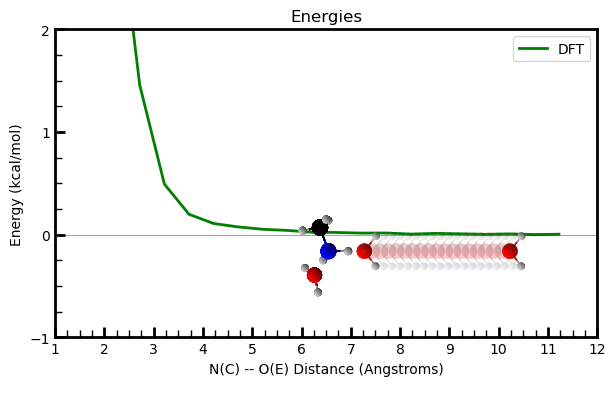

In [45]:
scan_CH3NH2_H2O_H2O_1_3b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_H2O_1, scan_CH3NH2_H2O_H2O_1_energies)

plot_scan(
        scan_CH3NH2_H2O_H2O_1,
        {"DFT": scan_CH3NH2_H2O_H2O_1_3b_energies},
        4,
        -3,
        title="Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[10].point, system.atoms[0].point)
)

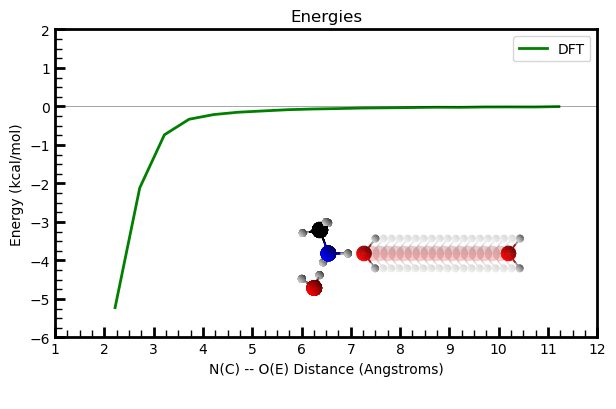

In [51]:
scan_CH3NH2_H2O_H2O_2_3b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_H2O_2, scan_CH3NH2_H2O_H2O_2_energies)

plot_scan(
        scan_CH3NH2_H2O_H2O_2,
        {"DFT": scan_CH3NH2_H2O_H2O_2_3b_energies},
        4,
        -3,
        title="Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[10].point, system.atoms[0].point)
)

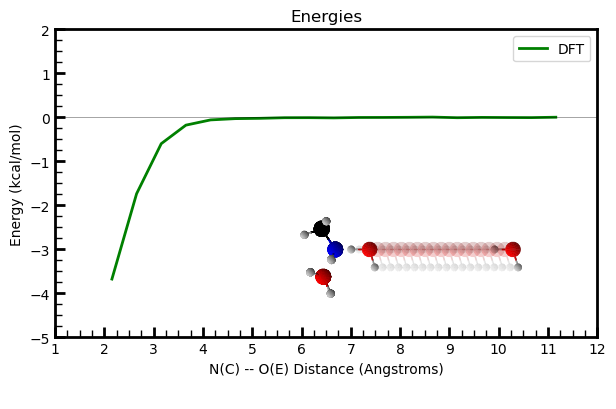

In [47]:
scan_CH3NH2_H2O_H2O_3_3b_energies = calculate_many_body_energies(scan_CH3NH2_H2O_H2O_3, scan_CH3NH2_H2O_H2O_3_energies)

plot_scan(
        scan_CH3NH2_H2O_H2O_3,
        {"DFT": scan_CH3NH2_H2O_H2O_3_3b_energies},
        4,
        -3,
        title="Energies",
        ymax=2,
        centerer=lambda system: system.atoms[4].point,
        aligner=lambda system: (system.atoms[-3].point, system.atoms[0].point)
)

## 2.x.y Clusters

In [136]:
calculator = QchemCalculator("HF", "STO-3G", log_directory=f"{logs_dir}")

In [202]:
clusters_CH3NH2_H2O = find_clusters(
        [minimized_structure_CH3NH2, minimized_structure_H2O],
        calculator=calculator,
        job_manager=get_qchem_job_manager(paths.jobs),
        num_guesses=10,
        restart_path=paths.restart.clusters_CH3NH2_H2O,
        guess_seed=123345,
        radius=5,
        num_threads=16,
        mem_mb=32000,
        similarity_threshold=0.1,
        filter_by_hbonds=True,
        hbond_cut=3.0
)
write_systems(paths.clusters.CH3NH2_H2O, clusters_CH3NH2_H2O)

Distance Distribution: dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Beginning random distance and rotation configuration generation.
Will generate 10 configs with distance distribution dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Done! Generated 10 configurations.
Minimizing geometries:  |====================================================================================================| - 10/10
Completed geometry minimizations!
Finding unique clusters:  |====================================================================================================| - 10/10
Found 3 unique minimized clusters.


In [203]:
HTML(render_systems(
        clusters_CH3NH2_H2O,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[4].point, system.atoms[1].point)
).to_jshtml())

In [215]:
clusters_CH3NH2_H2O_H2O = find_clusters(
        [minimized_structure_CH3NH2, minimized_structure_H2O, minimized_structure_H2O],
        calculator=calculator,
        job_manager=get_qchem_job_manager(paths.jobs),
        num_guesses=20,
        restart_path=paths.restart.clusters_CH3NH2_H2O_H2O,
        guess_seed=123345,
        radius=5,
        num_threads=16,
        mem_mb=32000,
        similarity_threshold=0.1,
        filter_by_hbonds=True,
        hbond_cut=2.5
)
write_systems(paths.clusters.CH3NH2_H2O_H2O, clusters_CH3NH2_H2O_H2O)

Distance Distribution: dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Beginning random distance and rotation configuration generation.
Will generate 20 configs with distance distribution dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Done! Generated 20 configurations.
Minimizing geometries:  |====================================================================================================| - 20/20
Completed geometry minimizations!
[(4, 12), (6, 7), (9, 10)]|                                                                                                    | - 0/20
[(4, 8), (7, 11)]usters:  |==========                                                                                          | - 2/20
[(3, 7), (4, 11), (8, 10)]|===============                                                                                     | - 3/20
[(4, 11), (6, 7)]usters:  |========================================                                                            | - 8/20
[(4, 12), (7, 11)]

In [217]:
HTML(render_systems(
        clusters_CH3NH2_H2O_H2O,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[4].point, system.atoms[1].point)
).to_jshtml())

In [240]:
clusters_tetramer = find_clusters(
        [minimized_structure_CH3NH2, minimized_structure_H2O, minimized_structure_H2O, minimized_structure_H2O],
        calculator=calculator,
        job_manager=get_qchem_job_manager(paths.jobs),
        num_guesses=20,
        restart_path=paths.restart.clusters_tetramer,
        guess_seed=123345,
        radius=5,
        num_threads=16,
        mem_mb=32000,
        similarity_threshold=1,
        filter_by_hbonds=True,
        hbond_cut=3.0
)
write_systems(paths.clusters.tetramer, clusters_tetramer)

Distance Distribution: dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Beginning random distance and rotation configuration generation.
Will generate 20 configs with distance distribution dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Done! Generated 20 configurations.
Minimizing geometries:  |====================================================================================================| - 20/20
Completed geometry minimizations!
Finding unique clusters:  |====================================================================================================| - 20/20
Found 12 unique minimized clusters.


In [241]:
HTML(render_systems(
        clusters_tetramer,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[4].point, system.atoms[1].point)
).to_jshtml())

In [250]:
clusters_pentamer = find_clusters(
        [minimized_structure_CH3NH2, minimized_structure_H2O, minimized_structure_H2O, minimized_structure_H2O, minimized_structure_H2O],
        calculator=calculator,
        job_manager=get_qchem_job_manager(paths.jobs),
        num_guesses=10,
        restart_path=paths.restart.clusters_pentamer,
        guess_seed=123345,
        radius=5,
        num_threads=16,
        mem_mb=32000,
        similarity_threshold=0.1,
        filter_by_hbonds=True,
        hbond_cut=3.0
)
write_systems(paths.clusters.pentamer, clusters_pentamer)

Distance Distribution: dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Beginning random distance and rotation configuration generation.
Will generate 10 configs with distance distribution dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Done! Generated 10 configurations.
Minimizing geometries:  |====================================================================================================| - 10/10
Completed geometry minimizations!
Finding unique clusters:  |====================================================================================================| - 10/10
Found 8 unique minimized clusters.


In [251]:
HTML(render_systems(
        clusters_pentamer,
        centerer=lambda system: system.atoms[0].point,
        aligner=lambda system: (system.atoms[4].point, system.atoms[1].point)
).to_jshtml())